<a href="https://colab.research.google.com/github/md499/uiuc-cs-598-final/blob/master/data_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
import random
import pandas as pd

In [ ]:
## the file path will be different if you try to run the code ###

data = pd.read_csv('/content/data.csv')
data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df = data.copy()
df = df.replace(-1.0, np.nan)

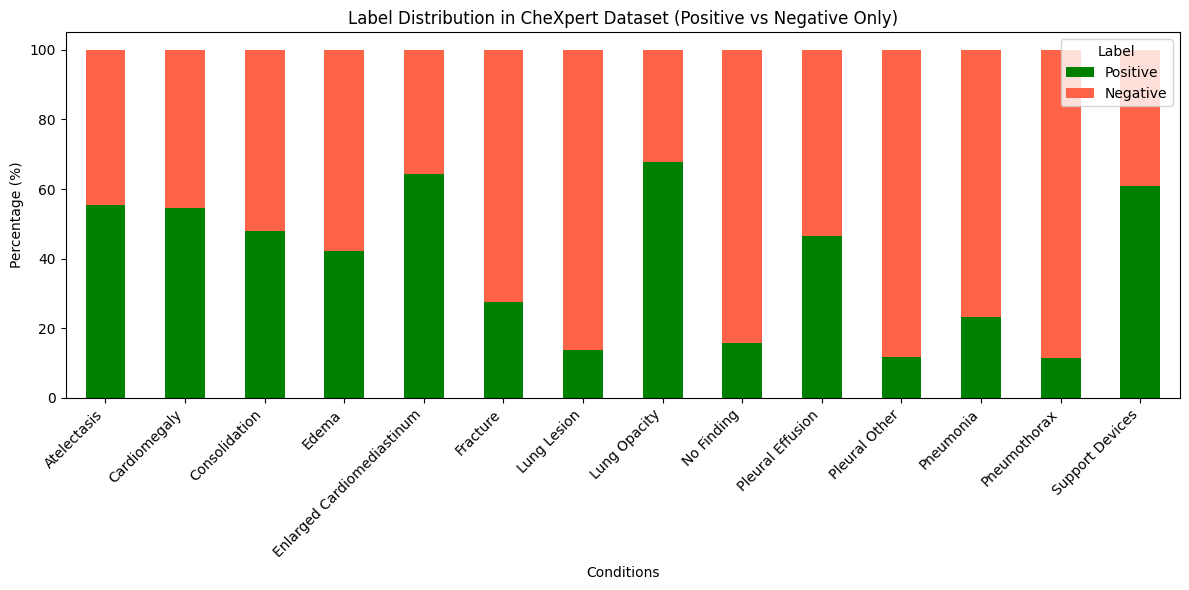

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CheXpert CSV (replace with your actual path)

# Columns representing labels
label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
    'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other',
    'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# Only consider -1 (uncertain), 0 (negative), 1 (positive)
df_filtered = df[label_cols].replace(-1.0, pd.NA).dropna()

# Count positive and negative for each condition
pos_counts = (df_filtered == 1.0).sum()
neg_counts = (df_filtered == 0.0).sum()

# Combine into one DataFrame
label_dist = pd.DataFrame({
    'Positive': pos_counts,
    'Negative': neg_counts
})

# Convert to percentage
label_dist_percent = label_dist.div(label_dist.sum(axis=1), axis=0) * 100

# Plot
label_dist_percent.plot(kind='bar', stacked=True, color=['green', 'tomato'], figsize=(12, 6))

plt.title('Label Distribution in CheXpert Dataset (Positive vs Negative Only)')
plt.xlabel('Conditions')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label')
plt.tight_layout()
plt.show()


In [14]:
# ---- Count Positive, Negative, Uncertain ----
positive_counts = (df[label_cols] == 1.0).sum()
negative_counts = (df[label_cols] == 0.0).sum()
uncertain_counts = df[label_cols].isin([-1.0]).sum()

label_dist = pd.DataFrame({
    'Positive': positive_counts,
    'Negative': negative_counts,
    'Uncertain': uncertain_counts
})

In [18]:
import pandas as pd

# Define data
labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion", "Lung Opacity",
    "No Finding", "Pleural Effusion", "Pleural Other", "Pneumonia",
    "Pneumothorax", "Support Devices"
]

descriptions = [
    "Partial or complete lung collapse",
    "Enlarged heart",
    "Lung filled with liquid instead of air",
    "Swelling caused by fluid accumulation",
    "Widening of the mediastinum",
    "Broken bone detected in imaging",
    "Abnormal mass or region in lung",
    "General increased density in lung",
    "No abnormal findings detected",
    "Fluid build-up in pleural space",
    "Other pleural-related abnormalities",
    "Lung infection (e.g., bacterial, viral)",
    "Air in chest cavity causing lung collapse",
    "Presence of wires, tubes, or implants"
]

positive = [302, 299, 295, 315, 308, 308, 289, 285, 304, 299, 298, 298, 303, 294]
negative = [567, 596, 595, 588, 581, 602, 601, 597, 603, 588, 596, 603, 593, 602]
uncertain = [131, 105, 110, 97, 111, 90, 110, 118, 93, 113, 106, 99, 104, 104]

# Build DataFrame
df = pd.DataFrame({
    "Label": labels,
    "Description": descriptions,
    "Positive": positive,
    "Negative": negative,
    "Uncertain": uncertain
})

# Compute totals and percentages using assign
df = df.assign(
    Total=lambda x: x[["Positive", "Negative", "Uncertain"]].sum(axis=1),
    **{
        "Positive %": lambda x: (x["Positive"] / x["Total"] * 100).round(1).astype(str) + "%",
        "Uncertain %": lambda x: (x["Uncertain"] / x["Total"] * 100).round(1).astype(str) + "%"
    }
)

# Reorder columns
df = df[["Label", "Description", "Positive", "Negative", "Uncertain", "Total", "Positive %", "Uncertain %"]]

### CONVERT TO CSV AND EXCEL
df.to_excel(chexpert_summary_table.csv, index=False)
df.to_csv(chexpert_summary_table.csv, index=False)


print(df)


                         Label                                Description  \
0                  Atelectasis          Partial or complete lung collapse   
1                 Cardiomegaly                             Enlarged heart   
2                Consolidation     Lung filled with liquid instead of air   
3                        Edema      Swelling caused by fluid accumulation   
4   Enlarged Cardiomediastinum                Widening of the mediastinum   
5                     Fracture            Broken bone detected in imaging   
6                  Lung Lesion            Abnormal mass or region in lung   
7                 Lung Opacity          General increased density in lung   
8                   No Finding              No abnormal findings detected   
9             Pleural Effusion            Fluid build-up in pleural space   
10               Pleural Other        Other pleural-related abnormalities   
11                   Pneumonia    Lung infection (e.g., bacterial, viral)   

In [ ]:
#### FOR THE TRAINING AND REPLICATION, SEE THE CODE IN paper_code.ipynb